

# Compute and visualize ERDS maps

This example calculates and displays ERDS maps of event-related EEG data.
ERDS (sometimes also written as ERD/ERS) is short for event-related
desynchronization (ERD) and event-related synchronization (ERS)
:footcite:`PfurtschellerLopesdaSilva1999`. Conceptually, ERD corresponds to a
decrease in power in a specific frequency band relative to a baseline.
Similarly, ERS corresponds to an increase in power. An ERDS map is a
time/frequency representation of ERD/ERS over a range of frequencies
:footcite:`GraimannEtAl2002`. ERDS maps are also known as ERSP (event-related
spectral perturbation) :footcite:`Makeig1993`.

In this example, we use an EEG BCI data set containing two different motor
imagery tasks (imagined hand and feet movement). Our goal is to generate ERDS
maps for each of the two tasks.

First, we load the data and create epochs of 5s length. The data set contains
multiple channels, but we will only consider C3, Cz, and C4. We compute maps
containing frequencies ranging from 2 to 35Hz. We map ERD to red color and ERS
to blue color, which is customary in many ERDS publications. Finally, we
perform cluster-based permutation tests to estimate significant ERDS values
(corrected for multiple comparisons within channels).


In [ ]:
# Adapted from 
#   Authors: Clemens Brunner <clemens.brunner@gmail.com>
#   Felix Klotzsche <klotzsche@cbs.mpg.de>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

As usual, we import everything we need.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from glob import glob

import mne
from mne import find_events
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_fif
from mne.stats import permutation_cluster_1samp_test as pcluster_test

First, we load and preprocess the data. We use runs 6, 10, and 14 from
subject 1 (these runs contains hand and feet motor imagery).



In [14]:
# fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))
# raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
# raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
# rename descriptions to be more easily interpretable
# raw.annotations.rename(dict(T1="hands", T2="feet"))

subject = "laurids"
subject = "chris"
raw_fnames = glob(f"data/scratch/{subject}/*4*/*raw.fif")
raw = concatenate_raws([read_raw_fif(f, preload=True) for f in raw_fnames])

Opening raw data file data/scratch/chris/4/4_raw.fif...
    Range : 0 ... 201843 =      0.000 ...   330.890 secs
Ready.
Reading 0 ... 201843  =      0.000 ...   330.890 secs...


In [15]:
raw.info['sfreq']

610.0

Now we can create 5-second epochs around events of interest.



In [36]:
tmin, tmax = -1, 4
events = find_events(raw, stim_channel='trigger', verbose=True)
classes = [90, 180, 270]
event_ids = {'90':"right", '180':"feet", '270':'left'} # map event IDs to tasks
annots = mne.annotations_from_events(events, raw.info['sfreq'], classes)
raw.set_annotations(annots)
raw.annotations.rename(event_ids)
# raw.set_eeg_reference(ref_channels=["Cz"])
# raw.apply_proj()

epochs = mne.Epochs(
    raw,
    events,
    event_id=[90, 180, 270],
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    picks=("C3", "Cz", "C4"),
    baseline=None,
    preload=True,
)

30 events found on stim channel trigger
Event IDs: [ 90 180 270]
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 3661 original time points ...
0 bad epochs dropped


In [17]:
raw.annotations

<Annotations | 30 segments: feet (10), left (10), right (10)>


Here we set suitable values for computing ERDS maps. Note especially the
``cnorm`` variable, which sets up an *asymmetric* colormap where the middle
color is mapped to zero, even though zero is not the middle *value* of the
colormap range. This does two things: it ensures that zero values will be
plotted in white (given that below we select the ``RdBu`` colormap), and it
makes synchronization and desynchronization look equally prominent in the
plots, even though their extreme values are of different magnitudes.



In [24]:
freqs = np.arange(2, 35)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

Finally, we perform time/frequency decomposition over all epochs.



Applying baseline correction (mode: percent)
Using a threshold of 1.833113
stat_fun(H1): min=-10.442502760739998 max=40.37045526101819
Running initial clustering …
Found 83 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  259.64it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-10.442502760739998 max=40.37045526101819
Running initial clustering …


Found 110 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  250.64it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-8.430812134940943 max=46.61455002436992
Running initial clustering …
Found 121 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  241.16it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-8.430812134940943 max=46.61455002436992
Running initial clustering …
Found 89 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  251.10it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-14.368252688601904 max=34.692560834986224
Running initial clustering …
Found 95 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  251.27it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-14.368252688601904 max=34.692560834986224
Running initial clustering …
Found 94 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  257.69it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  230.22it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied


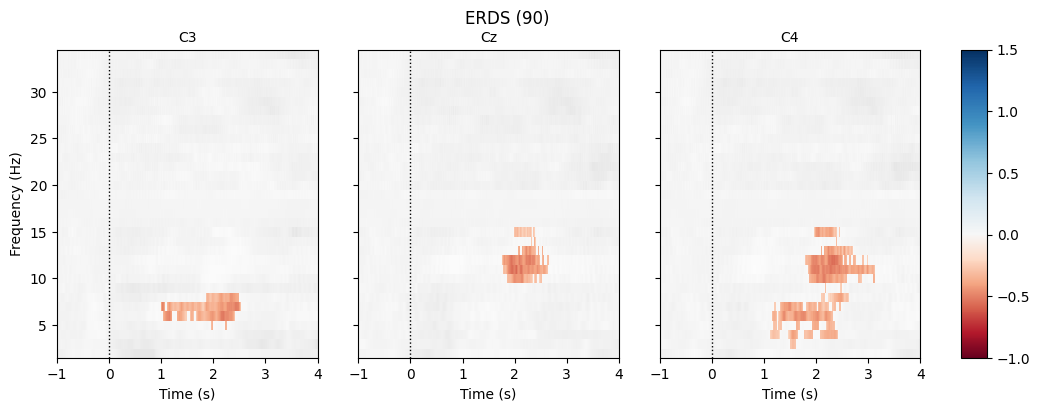

Using a threshold of 1.833113
stat_fun(H1): min=-7.52406812712178 max=14.609007685463647
Running initial clustering …
Found 119 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  248.33it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-7.52406812712178 max=14.609007685463647
Running initial clustering …


Found 136 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  230.89it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-7.903014312176044 max=14.057135051735973
Running initial clustering …
Found 113 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  228.26it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-7.903014312176044 max=14.057135051735973
Running initial clustering …
Found 117 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  236.81it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-11.463396182986791 max=15.827100061744956
Running initial clustering …
Found 107 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  227.33it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-11.463396182986791 max=15.827100061744956
Running initial clustering …
Found 130 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  241.85it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied


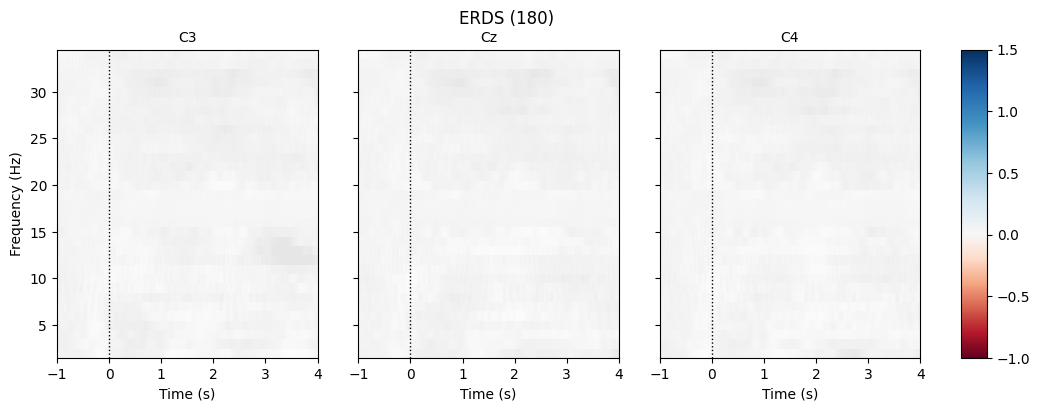

Using a threshold of 1.833113
stat_fun(H1): min=-7.327004228573963 max=42.10874351730804
Running initial clustering …
Found 79 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  252.50it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-7.327004228573963 max=42.10874351730804
Running initial clustering …
Found 115 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  249.56it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-7.948016553241555 max=36.66824649810144
Running initial clustering …
Found 81 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  252.22it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-7.948016553241555 max=36.66824649810144
Running initial clustering …
Found 96 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  261.62it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-5.422001368070426 max=32.47306763913888
Running initial clustering …
Found 102 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  245.37it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-5.422001368070426 max=32.47306763913888
Running initial clustering …


Found 102 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  242.39it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied


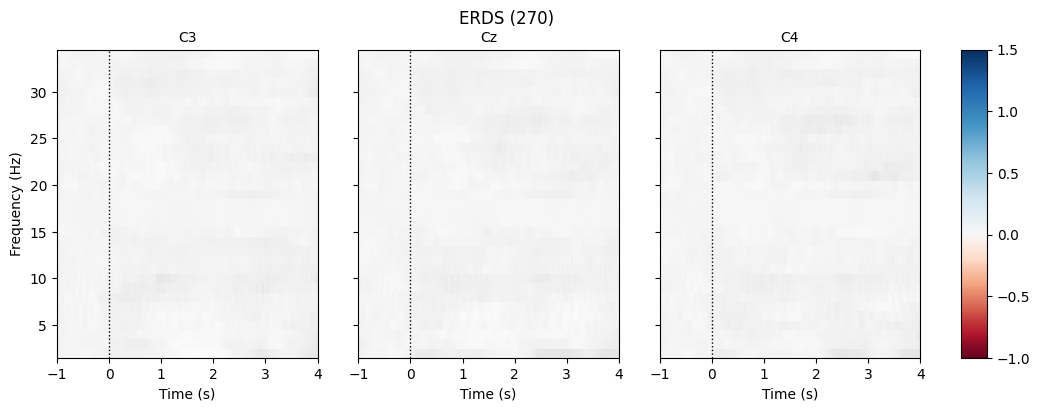

In [25]:
tfr = epochs.compute_tfr(
    method="multitaper",
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Similar to `~mne.Epochs` objects, we can also export data from
`~mne.time_frequency.EpochsTFR` and `~mne.time_frequency.AverageTFR` objects
to a :class:`Pandas DataFrame <pandas.DataFrame>`. By default, the `time`
column of the exported data frame is in milliseconds. Here, to be consistent
with the time-frequency plots, we want to keep it in seconds, which we can
achieve by setting ``time_format=None``:



In [ ]:
df = tfr.to_data_frame(time_format=None)
df

This allows us to use additional plotting functions like
:func:`seaborn.lineplot` to plot confidence bands:



In [ ]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Having the data as a DataFrame also facilitates subsetting,
grouping, and other transforms.
Here, we use seaborn to plot the average ERDS in the motor imagery interval
as a function of frequency band and imagery condition:



In [ ]:
df_mean = (
    df.query("time > 1")
    .groupby(["condition", "epoch", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)

g = sns.FacetGrid(
    df_mean, col="condition", col_order=["right", "feet", "left"], margin_titles=True
)
g = g.map(
    sns.violinplot,
    "channel",
    "value",
    "band",
    cut=0,
    palette="deep",
    order=["C3", "Cz", "C4"],
    hue_order=freq_bands_of_interest,
    linewidth=0.5,
).add_legend(ncol=4, loc="lower center")

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

In [132]:
epochs_new = mne.Epochs(
    raw,
    events,
    event_id=[90],
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    picks=("C3", "Cz", "C4"),
    baseline=(-0.5, 0),
    preload=True,
)

Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 3661 original time points ...
0 bad epochs dropped


In [133]:
freqs = np.logspace(*np.log10([8, 30]), num=16)
freqs = np.arange(7, 31) 
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = epochs_new.compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    average=True,
    return_itc=True,
    decim=3
)

In [134]:
vmin, vmax = -8, 8  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

Applying baseline correction (mode: zlogratio)


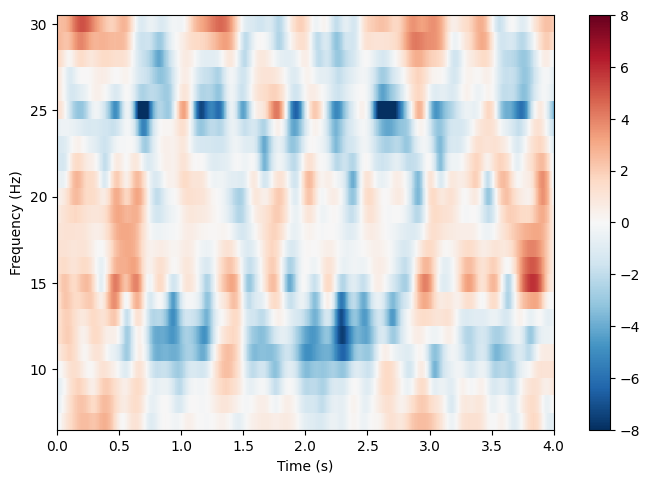

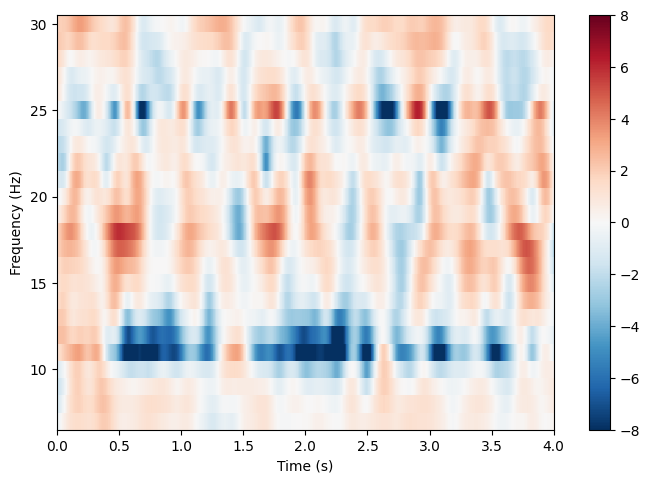

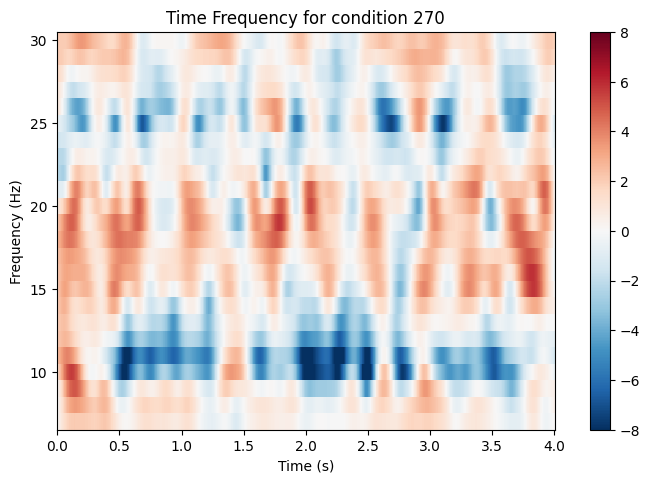

In [136]:
power.plot(picks=["eeg"], baseline=(-0.5, 0), mode="zlogratio", tmin=0, tmax=4, combine="mean", cnorm=cnorm, show=False)
plt.title("Time Frequency for condition 90");

Applying baseline correction (mode: zlogratio)


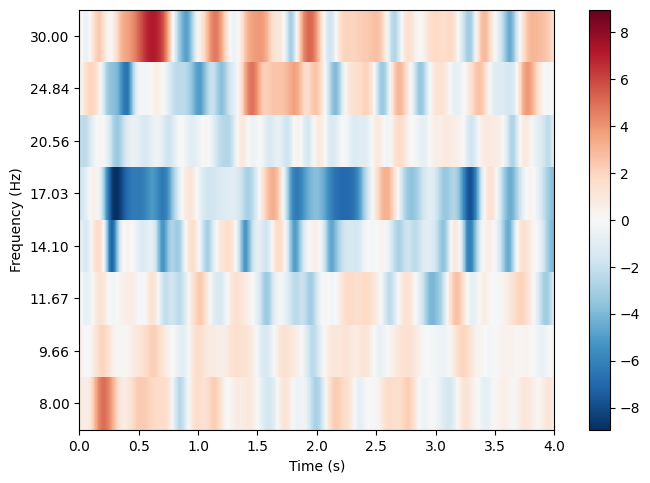

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


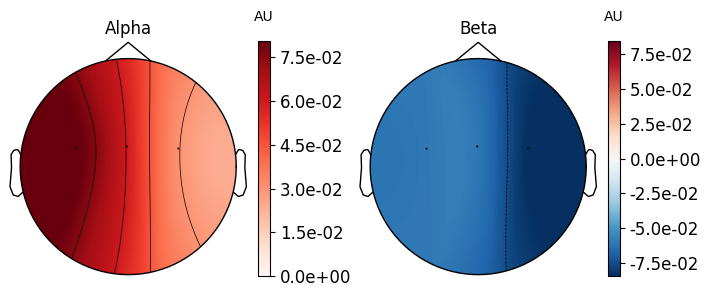

In [122]:
#power.plot_topo(baseline=(-0.5, 0), mode="logratio", title="Average power")
power.plot(picks=["eeg"], baseline=(-0.5, 0), mode="zlogratio", tmin=0, tmax=4, combine="mean")

fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=0.5, tmax=1.5, baseline=(-0.5, 0), mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)

## References
.. footbibliography::

